In [1]:
%matplotlib inline
import numpy as np
import h5py
import tables
import pandas as pd
import os
import sys
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib as mpl
import pickle
import re
import keras
from collections import defaultdict
import warnings
from functools import lru_cache
# import seaborn as sns

Using TensorFlow backend.


In [3]:
mpl.rcParams["figure.figsize"] = (8,5)

In [2]:
hdf5_files = sorted(glob.glob("*.hdf5"))
hdf5_files

[]

In [12]:

f = pd.HDFStore(hdf5_files[0], "r")


In [13]:
f.keys()

[]

In [14]:
hdf5_files = sorted(glob.glob("../hdf/*.hdf5"))
hdf5_files

['../hdf/Level2_nugen_numu_IC86.2012.011069.000000.hdf5',
 '../hdf/Level2_nugen_numu_IC86.2012.011069.000001.hdf5',
 '../hdf/Level2_nugen_numu_IC86.2012.011069.000002.hdf5',
 '../hdf/test.hdf5']

In [15]:
regex_mcd = re.compile("Level\d_\w*_\w*_IC\d{2}.\d{4}.(\d{6}).(\d{6}).hdf5")

In [16]:
match = regex_mcd.search(hdf5_files[0])

In [17]:
match.string

'../hdf/Level2_nugen_numu_IC86.2012.011069.000000.hdf5'

In [18]:
for hdf5_file in hdf5_files:
    match = regex_mcd.search(hdf5_file)
    if match is not None:
        print(match.string)
        print(match.groups())

../hdf/Level2_nugen_numu_IC86.2012.011069.000000.hdf5
('011069', '000000')
../hdf/Level2_nugen_numu_IC86.2012.011069.000001.hdf5
('011069', '000001')
../hdf/Level2_nugen_numu_IC86.2012.011069.000002.hdf5
('011069', '000002')


In [24]:
hdf5_test_file = hdf5_files[0]
print(hdf5_test_file)

../hdf/Level2_nugen_numu_IC86.2012.011069.000000.hdf5


In [25]:
def get_dataframe_from_hdffile(hdf5_filename):
    data_keys = ["DOMPulseBinIndices", "DOMPulseBinValues"]
    hdf_file = pd.HDFStore(hdf5_filename, "r")
    pos_charge_df = hdf_file[data_keys[0]].assign(charge=hdf_file[data_keys[1]].item.values)
    pos_charge_df.rename(columns = {'item':'timebin'}, inplace = True)
    hdf_file.close()
    return pos_charge_df

In [26]:
hdf5_dataframe = get_dataframe_from_hdffile(hdf5_test_file)
hdf5_dataframe.head(10)

,Run,Event,SubEvent,SubEventStream,exists,string,om,pmt,vector_index,timebin,charge
0,1106900000,1,0,1,1,1,25,0,0,9,0.775
1,1106900000,1,0,1,1,2,1,0,0,12,0.275
2,1106900000,1,0,1,1,17,6,0,0,24,1.375
3,1106900000,1,0,1,1,19,59,0,0,0,1.275
4,1106900000,1,0,1,1,19,59,0,1,24,0.375
5,1106900000,1,0,1,1,21,48,0,0,24,0.625
6,1106900000,1,0,1,1,30,31,0,0,0,1.675
7,1106900000,1,0,1,1,31,27,0,0,24,4.325
8,1106900000,1,0,1,1,31,58,0,0,0,1.175
9,1106900000,1,0,1,1,32,17,0,0,0,0.675


In [27]:
def get_pos_charge_dataframe(hdf5_dataframe, reindex=True):
    hdf5_dataframe.drop(["Run", "SubEventStream", "exists", "pmt", "vector_index"], axis=1, inplace=True)
    if reindex:
        hdf5_dataframe.set_index(["Event","SubEvent","timebin","string","om"], inplace=True)
        hdf5_dataframe.sort_index(inplace=True)
    return hdf5_dataframe

In [28]:
string_om_charge_dataframe = get_pos_charge_dataframe(hdf5_dataframe)
string_om_charge_dataframe.head(10)

charge
Event SubEvent timebin string om             
1     0        0       19     59     1.275000
                       30     31     1.675000
                       31     58     1.175000
                       32     17     0.675000
                       60     50     1.375000
                       63     37     0.925000
                       69     2      2.250000
                       86     20     1.625000
               2       77     1    907.675005
                              2   1332.800013

In [29]:
def get_label_dataframe(hdf5_filename):
    label_key = "DLClassificationLabel"
    columns = ["Event","SubEvent","event_type", "event_subtype"]
    hdf_file = pd.HDFStore(hdf5_filename, "r")
    label_df = hdf_file[label_key][columns].set_index(["Event","SubEvent"])
    hdf_file.close()
    return label_df
    

In [30]:
label_dataframe = get_label_dataframe(hdf5_test_file)
label_dataframe.head(10)

,,event_type,event_subtype
Event,SubEvent,,
1,0,0,-1
4,0,2,-1
9,0,2,-1
14,0,1,-1
33,0,0,-1
58,0,1,-1
66,0,0,-1
69,0,2,-1
73,0,0,-1


In [31]:
def parse_labels(split_labels):
    label_names = {"track":0, "cascade":1, "faint":2, 
                   "starting_track":3, "stopping_track":4,
                   "contained_track":5, "trough_track":6,
                   "full_cascade":7, "part_cascade":8}
    label_dict = {(0,-1): label_names["track"],
                  (0,0): label_names["starting_track"],
                  (0,1): label_names["stopping_track"],
                  (0,2): label_names["contained_track"],
                  (0,3): label_names["trough_track"],
                  (1, -1): label_names["cascade"],
                  (1,0): label_names["full_cascade"],
                  (1,1): label_names["part_cascade"],
                  (2,-1): label_names["faint"]}
    
    labels = np.zeros(shape=(split_labels.shape[0]), dtype=np.int32)
    for i, label in enumerate(split_labels):
        labels[i] = label_dict[tuple(label)]
    return labels
    
def get_events_and_labels(label_dataframe):    
    events = label_dataframe.index.values
    labels = parse_labels(label_dataframe.values)
    return events, labels

In [32]:
events, labels = get_events_and_labels(label_dataframe)

print(events[:10])
print(labels[:10])


[(1, 0) (4, 0) (9, 0) (14, 0) (33, 0) (58, 0) (66, 0) (69, 0) (73, 0)
 (78, 0)]
[0 2 2 1 0 1 0 2 0 0]


In [33]:
def get_string_om_charge_by_timebin(event_dataframe):    
    if "Event" in event_dataframe.index.names: 
        raise ValueError("'Event' column found in dataframe, but a dataframe of one specific event is needed.")
    elif "SubEvent" in event_dataframe.index.names:
        raise ValueError("'SubEvent' column found in dataframe, but a dataframe of one specific event is needed.")
    string_om_charge_by_timebin = {}
    string_om_charge = (i for i in zip(event_dataframe.index,event_dataframe.charge.values))
    for soc in string_om_charge:
        try:
            string_om_charge_by_timebin[soc[0][0]].append((soc[0][1], soc[0][2], soc[1]))
        except:
            string_om_charge_by_timebin[soc[0][0]] = [(soc[0][1], soc[0][2], soc[1])]
    string_om_charge_by_timebin = defaultdict(lambda: [], string_om_charge_by_timebin)
    return string_om_charge_by_timebin

In [34]:
time_to_soc_dict = get_string_om_charge_by_timebin(string_om_charge_dataframe.loc[1,0])

for k,vl in list(time_to_soc_dict.items())[:2]:
    print("Timebin: {}".format(k))
    for v in vl:
        print("StringOmCharge: {}".format(v))


Timebin: 0
StringOmCharge: (19, 59, 1.2749999761581421)
StringOmCharge: (30, 31, 1.6749999523162842)
StringOmCharge: (31, 58, 1.1749999523162842)
StringOmCharge: (32, 17, 0.67500001192092896)
StringOmCharge: (60, 50, 1.375)
StringOmCharge: (63, 37, 0.92500001192092896)
StringOmCharge: (69, 2, 2.25)
StringOmCharge: (86, 20, 1.625)
Timebin: 2
StringOmCharge: (77, 1, 907.67500495910645)
StringOmCharge: (77, 2, 1332.8000133037567)
StringOmCharge: (77, 3, 744.37500554323196)
StringOmCharge: (77, 4, 225.44999706745148)
StringOmCharge: (77, 5, 1.3250000476837158)


In [35]:
@lru_cache(maxsize=1)
def load_geometry_dict(geodict_path):
    with open(geodict_path, "rb") as geo:
        geodict = pickle.load(geo)
    return geodict

In [36]:
dom_geometry_dict = load_geometry_dict("domdict.pickle")
for k,v in list(dom_geometry_dict.items())[:3]:
    print("{}:{}".format(k,v))

(53, 53):((-234.9499969482422, 140.44000244140625, -385.010009765625), 'IceCube')
(57, 50):((257.30999755859375, 211.66000366210938, -329.5899963378906), 'IceCube')
(40, 22):((544.0700073242188, 55.88999938964844, 145.35000610351562), 'IceCube')


In [37]:
def get_positions_in_timebins(timebin_position_dict, dom_geometry_dict, timebins):
    if isinstance(timebins, int):
        timebins = (timebins,)
    positions = None
    for i,timebin in enumerate(timebins):
        current_positions = []
        for soc in timebin_position_dict[timebin]:
            current_positions.append(list(dom_geometry_dict[soc[0:2]][0]))        
        if positions is not None:
            if current_positions:
                positions = np.vstack([positions, current_positions])
        else:
            positions = np.array(current_positions)
    return positions

In [38]:
positions_in_timebins_0 = get_positions_in_timebins(time_to_soc_dict, dom_geometry_dict, timebins=0)
positions_in_timebins_1 = get_positions_in_timebins(time_to_soc_dict, dom_geometry_dict, timebins=1)
positions_in_timebins_2 = get_positions_in_timebins(time_to_soc_dict, dom_geometry_dict, timebins=2)
positions_in_timebins_012 = get_positions_in_timebins(time_to_soc_dict, dom_geometry_dict, timebins=range(3))
print("Timebin 0:\n", positions_in_timebins_0)
print("Timebin 1:\n", positions_in_timebins_1)
print("Timebin 2:\n", positions_in_timebins_2)
print("Timebin 3:\n", positions_in_timebins_012)

assert np.all(np.vstack([positions_in_timebins_0, positions_in_timebins_2]) == positions_in_timebins_012)

Timebin 0:
 [[ 210.47000122 -209.77000427 -490.26000977]
 [ 500.42999268  -58.45000076   -8.77000046]
 [-570.90002441 -125.13999939 -470.57998657]
 [-447.73999023 -113.12999725  228.33999634]
 [-437.04000854  217.80000305 -332.54998779]
 [ -66.69999695  276.92001343 -114.91999817]
 [-268.8999939   354.23999023  484.51000977]
 [ -10.97000027    6.71999979 -220.08000183]]
Timebin 1:
 []
Timebin 2:
 [[-101.05999756  490.22000122  501.48999023]
 [-101.05999756  490.22000122  484.45999146]
 [-101.05999756  490.22000122  467.44000244]
 [-101.05999756  490.22000122  450.42001343]
 [-101.05999756  490.22000122  433.3999939 ]]
Timebin 3:
 [[ 210.47000122 -209.77000427 -490.26000977]
 [ 500.42999268  -58.45000076   -8.77000046]
 [-570.90002441 -125.13999939 -470.57998657]
 [-447.73999023 -113.12999725  228.33999634]
 [-437.04000854  217.80000305 -332.54998779]
 [ -66.69999695  276.92001343 -114.91999817]
 [-268.8999939   354.23999023  484.51000977]
 [ -10.97000027    6.71999979 -220.08000183]
 [

In [39]:
def get_charge_in_timebins(timebin_position_dict, timebins):
    if isinstance(timebins, int):
        timebins = (timebins,)
    charges = []
    for i, timebin in enumerate(timebins):
        bin_charges = []
        for string_om_charge in timebin_position_dict[timebin]:        
            bin_charges.append(string_om_charge[2])
        charges.extend(bin_charges)
    return np.array(charges)

In [40]:
charges_in_timebins_012 = get_charge_in_timebins(time_to_soc_dict, timebins=range(3))
charges_in_timebins_012

array([  1.27499998e+00,   1.67499995e+00,   1.17499995e+00,
         6.75000012e-01,   1.37500000e+00,   9.25000012e-01,
         2.25000000e+00,   1.62500000e+00,   9.07675005e+02,
         1.33280001e+03,   7.44375006e+02,   2.25449997e+02,
         1.32500005e+00])

In [41]:
def get_positions_and_charges_in_timebins(timebin_string_om_dict, dom_geometry_dict, timebins):
    if isinstance(timebins, int):
        timebins = (timebins,)
    positions = None
    charges = []
    for i, timebin in enumerate(timebins):
        current_positions = []
        bin_charges = []
        for soc in timebin_string_om_dict[timebin]:
            current_positions.append(list(dom_geometry_dict[soc[0:2]][0]))    
            bin_charges.append(soc[2])
        if positions is not None:
            if current_positions:
                positions = np.vstack([positions, current_positions])
        else:
            positions = np.array(current_positions)
        charges.extend(bin_charges)
    return positions, np.asarray(charges)

In [42]:
positions_in_timebins_012_, charges_in_timebins_012_ = get_positions_and_charges_in_timebins(time_to_soc_dict, dom_geometry_dict, timebins=range(3))
assert np.all(positions_in_timebins_012 == positions_in_timebins_012_)
assert np.all(charges_in_timebins_012 == charges_in_timebins_012_)

In [43]:
def histplot(positions, charges, cbars=False, normed=False, return_histograms=False):    
    hist_xy, _, _ = np.histogram2d(*positions[:,[0,1]].T, bins=(25,25), weights=np.log(charges+1),
                                   range=((-600,600),(-600,600)), normed=normed)
    hist_yz, _, _ = np.histogram2d(*positions[:,[1,2]].T, bins=(25,25), weights=np.log(charges+1),
                                   range=((-600,600),(-600,600)), normed=normed)
    hist_xz, _, _ = np.histogram2d(*positions[:,[0,2]].T, bins=(25,25), weights=np.log(charges+1),
                                   range=((-600,600),(-600,600)), normed=normed)

    fig, axes = plt.subplots(nrows=1, ncols=3)
    ax_xy, ax_yz, ax_xz = np.ravel(axes)
    ax_xy.set_xlabel("x")
    ax_xy.set_ylabel("y")
    ax_yz.set_xlabel("y")
    ax_yz.set_ylabel("z")
    ax_xz.set_xlabel("x")
    ax_xz.set_ylabel("z")

    ax_xy.set_aspect("equal")
    im_xy = ax_xy.imshow(np.log(hist_xy.T+1), origin="lower", extent=(-600, 600, -600, 600), cmap="viridis", vmin=0)
    im_yz = ax_yz.imshow(np.log(hist_yz.T+1), origin="lower", extent=(-600, 600, -600, 600), cmap="viridis", vmin=0)
    im_xz = ax_xz.imshow(np.log(hist_xz.T+1), origin="lower", extent=(-600, 600, -600, 600), cmap="viridis", vmin=0)
    if cbars:
        for im,ax in zip([im_xy, im_yz, im_xz],[ax_xy, ax_yz, ax_xz]):
            cbar = plt.colorbar(im, ax=ax, orientation="horizontal")
            cbar.set_label("Number of Pulses")
    if return_histograms:
        return hist_xy, hist_yz, hist_xz

In [57]:
def get_4d_event_histogram(timebin_string_om_dict, dom_geometry_dict,
                           number_txyz_bins=(25, 25, 25, 25)):
    hist_txyz = np.zeros(shape=number_txyz_bins)
    for timebin in range(number_txyz_bins[0]):
        positions, charges = get_positions_and_charges_in_timebins(timebin_string_om_dict,
                                                                   dom_geometry_dict,
                                                                   timebins=timebin)
        if positions.shape[0] > 0:
            hist_xyz, _ = np.histogramdd(positions, weights=np.log1p(charges), bins=number_txyz_bins[1:],
                                         range=((-600, 600), (-600, 600), (-600, 600)))
            hist_txyz[timebin, :, :, :] = hist_xyz
    return hist_txyz

In [45]:
event_histogram_txyz = get_4d_event_histogram(time_to_soc_dict, dom_geometry_dict, number_txyz_bins=(25,25,25,25))

In [2]:
def project_4d_histogram_onto_plane(hist4d, projection="xy", transpose=True):
    axis_by_dimension = {"t":0, "x":1, "y":2, "z":3}
    axis_left = [] 
    for name, number in axis_by_dimension.items():
        if not name in projection:
            axis_left.append(number)
    axis_left.sort()
    return np.sum(hist4d, axis=tuple(axis_left)).T if transpose else np.sum(hist4d, axis=tuple(axis_left))

In [47]:
xz_projection = project_4d_histogram_onto_plane(event_histogram_txyz, projection="xz")
xz_projection


array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.51581317,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,    0.        ],
       [   1.55405729,    0.        ,    0.        ,    0.95551144,
           1.41113938,   10.25169982,   16.48436376,    2.93270667,
          10.090

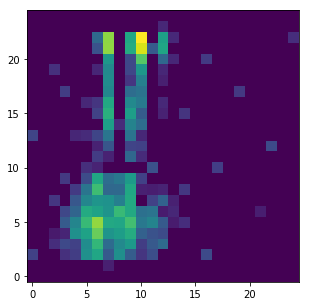

In [48]:
plt.imshow(np.log1p(xz_projection), origin="lower")

In [49]:
def gen_formatted_mcdata_filename(mcdata_filename):
    path, filename = os.path.split(mcdata_filename)
    filename_parts = filename.split(".")
    filename_parts.insert(-1, "formatted")
    filename_formatted = ".".join(filename_parts)
    return os.path.join(path, filename_formatted)


In [50]:
gen_formatted_mcdata_filename(hdf5_test_file)

'../hdf/Level2_nugen_numu_IC86.2012.011069.000000.formatted.hdf5'

In [51]:
def write_events_and_labels_to_hdf(hdf_filepath, run_dataframe, events, labels, dom_geometry_dict,
                                   data_key="EventData", labels_key="EventLabels"):
    num_events = len(events)
    num_labels = len(labels)
    if num_events != num_labels:
        # @improve: replace with warning add logging
        raise ValueError("length of arguments `events` ({}) and `labels` ({}) must be the same.".format(num_events, num_labels))
    with h5py.File(hdf_filepath, "w") as hdf_file:
        hdf_file.create_dataset(labels_key, data=labels)
        data_group = hdf_file.create_group(data_key)
        max_event_digits = int(np.log10(max(events)[0])) + 1
        for event in events:
            event_format = "event_{event:0{digits}}_{subevent}"
            event_name = event_format.format(digits=max_event_digits, event=event[0], subevent=event[1])
            event_binned = get_4d_event_histogram(get_string_om_charge_by_timebin(run_dataframe.loc[event]),
                                                  dom_geometry_dict)
            data_group.create_dataset(event_name, data=event_binned)
        hdf_file.flush()

In [1038]:
np.array([1,2,3,4])@np.array([1,3])

ValueError: shapes (4,) and (2,) not aligned: 4 (dim 0) != 2 (dim 0)

In [1015]:
df = get_pos_charge_dataframe(get_dataframe_from_hdffile(hdf5_files[0]), reindex=True)

In [994]:
df.head(10)


charge
Event SubEvent timebin string om             
1     0        0       19     59     1.275000
                       30     31     1.675000
                       31     58     1.175000
                       32     17     0.675000
                       60     50     1.375000
                       63     37     0.925000
                       69     2      2.250000
                       86     20     1.625000
               2       77     1    907.675005
                              2   1332.800013

In [1259]:
df = string_om_charge_dataframe

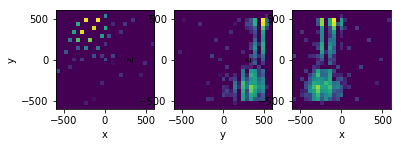

In [1282]:
pos,charge = get_positions_and_charges_in_timebins(get_string_om_charge_by_timebin(df.loc[1,0]), dom_geometry_dict, timebins=range(25))
xy,yz,xz = histplot(pos, charge, return_histograms=True)

In [1286]:
yz.T == project4d(event_histogram_txyz, projection="yz")

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True, False,  True, False,
        False, False, False, False, False,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True, False,  True, False,
        False, False, False, False, False,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True, False,  True, False,
        False, False, False, False, False,  True,  True],


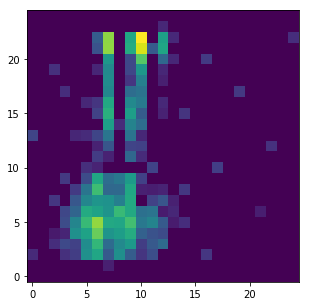

In [628]:
plt.imshow(np.log(project4d(test_res, projection="xz")+1), origin="lower")

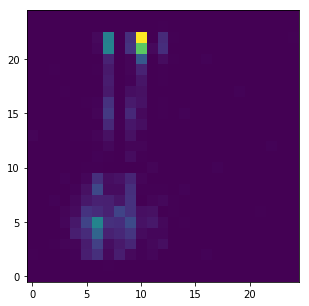

In [627]:
plt.imshow(xz.T, origin="lower")

In [ ]:
events = get_events_in_run(hdf5_files[0])

In [651]:
event_1_binned = get_4d_event_histogram(get_string_om_charge_by_timebin(df.loc[1]))
event_4_binned = get_4d_event_histogram(get_string_om_charge_by_timebin(df.loc[4]))

In [1019]:
events, labels = get_events_and_labels(hdf5_files[0])

print(events[:10])
print(labels[:10])


[(1, 0) (4, 0) (9, 0) (14, 0) (33, 0) (58, 0) (66, 0) (69, 0) (73, 0)
 (78, 0)]
[0 2 2 1 0 1 0 2 0 0]


In [1024]:
max(events)

(5029, 0)

In [646]:
event_1_binned.shape

(25, 25, 25, 25)

In [120]:
fraction_events = np.random.uniform(0,1,size=1)
fraction_events

array([ 0.22148879])

In [121]:
number_mcdata_events = len(events)
number_mcdata_events

773

In [122]:
number_mcdata_selection = int(number_mcdata_events * fraction_events)
number_mcdata_selection

171

In [130]:
def select_events_labels(events, labels, fraction_events, return_selection_args=False):    
    number_mcdata_events = len(events)
    number_mcdata_selection = int(number_mcdata_events * fraction_events)
    mask = np.zeros(shape=number_mcdata_events)
    selected_args = np.random.choice(np.arange(0,number_mcdata_events), 
                                 size=number_mcdata_selection, replace=False)
    mask[selected_args] = 1
    events_selected = np.compress(mask, events)
    labels_selected = np.compress(mask, labels)
    if return_selection_args:
        return events_selected, labels_selected, selected_args
    else:
        return events_selected, labels_selected

In [135]:
import hypothesis as hyp
import hypothesis.strategies as hyp_strat

In [139]:
@hyp.given(hyp_strat.floats(min_value=0, max_value=1))
def test_select_events_labels(events, labels, fraction_events):
    events_selected, labels_selected, selected_args = select_events_labels(events, labels, fraction_events, return_selection_args=True)
    selected_args.sort()
    for i,arg in enumerate(selected_args):
        assert np.all(events_selected[i] == events[arg])
        assert np.all(labels_selected[i] == labels[arg])

In [141]:
test_select_events_labels(events, labels)

In [125]:
selected_args.sort()
selected_args

array([  0,   3,   5,  10,  12,  16,  25,  27,  31,  33,  36,  39,  42,
        46,  53,  61,  64,  71,  76,  81,  84,  86,  90,  93,  98, 106,
       111, 112, 132, 140, 141, 146, 160, 161, 163, 164, 165, 171, 173,
       177, 180, 182, 184, 192, 195, 197, 198, 200, 201, 207, 216, 217,
       220, 221, 224, 226, 232, 241, 244, 251, 254, 265, 266, 270, 271,
       272, 273, 275, 278, 282, 285, 290, 297, 306, 308, 318, 319, 324,
       325, 350, 355, 358, 362, 369, 378, 381, 387, 415, 424, 425, 430,
       431, 452, 455, 469, 471, 480, 483, 484, 486, 489, 495, 496, 499,
       501, 503, 510, 520, 530, 536, 538, 543, 544, 545, 551, 557, 560,
       562, 564, 571, 572, 575, 576, 577, 583, 587, 592, 595, 600, 601,
       602, 603, 605, 606, 616, 618, 620, 624, 625, 634, 635, 646, 647,
       648, 649, 652, 656, 658, 659, 665, 676, 682, 688, 690, 692, 694,
       701, 707, 708, 718, 722, 723, 725, 729, 730, 740, 746, 755, 756,
       759, 765])

In [126]:
events_selected

array([(1, 0), (14, 0), (58, 0), (82, 0), (120, 0), (146, 0), (186, 0),
       (204, 0), (215, 0), (223, 0), (237, 0), (258, 0), (275, 0),
       (313, 0), (336, 0), (391, 0), (405, 0), (434, 0), (454, 0),
       (479, 0), (518, 0), (524, 0), (536, 0), (555, 0), (592, 0),
       (678, 0), (705, 0), (709, 0), (813, 0), (919, 0), (928, 0),
       (950, 0), (1049, 0), (1051, 0), (1060, 0), (1070, 0), (1074, 0),
       (1092, 0), (1096, 0), (1128, 0), (1164, 0), (1175, 0), (1179, 0),
       (1218, 0), (1241, 0), (1252, 0), (1281, 0), (1311, 0), (1321, 0),
       (1371, 0), (1424, 0), (1428, 0), (1455, 0), (1456, 0), (1490, 0),
       (1506, 0), (1527, 0), (1582, 0), (1591, 0), (1638, 0), (1650, 0),
       (1706, 0), (1712, 0), (1737, 0), (1738, 0), (1757, 0), (1762, 0),
       (1774, 0), (1786, 0), (1801, 0), (1817, 0), (1846, 0), (1873, 0),
       (1914, 0), (1919, 0), (1972, 0), (1975, 0), (2014, 0), (2021, 0),
       (2182, 0), (2251, 0), (2267, 0), (2291, 0), (2330, 0), (2414, 0),
    

In [107]:
labels_selected

array([0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 2, 1,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 0, 1, 0, 1, 1, 2,
       0, 0, 1, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 0, 2, 2, 0, 2, 0, 2,
       2, 0, 1, 1, 2, 0, 1, 0], dtype=int32)

In [102]:
%%timeit
events[sorted(selected_args)]

30.5 µs ± 328 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [103]:
%%timeit


11.6 µs ± 286 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [58]:
write_events_and_labels_to_hdf("binned_data.hdf5", df, events[:10], labels[:10])

NameError: name 'df' is not defined

In [6]:
def _write_events_and_labels_to_hdf(hdf_filepath, run_dataframe, events, labels, dom_geometry_dict,
                                   data_key="EventData", labels_key="EventLabels"):
    num_events = len(events)
    num_labels = len(labels)
    if num_events != num_labels:
        # @improve: replace with warning add logging
        raise ValueError("length of arguments `events` ({}) and `labels` ({}) must be the same.".format(num_events, num_labels))
    with h5py.File(hdf_filepath, "w") as hdf_file:
        hdf_file.create_dataset(labels_key, data=labels)
        data_group = hdf_file.create_group(data_key)
        max_event_digits = int(np.log10(max(events)[0])) + 1
        for event in events:
            event_format = "event_{event:0{digits}}_{subevent}"
            event_name = event_format.format(digits=max_event_digits, event=event[0], subevent=event[1])
            event_binned = get_4d_event_histogram(get_string_om_charge_by_timebin(run_dataframe.loc[event]),
                                                  dom_geometry_dict)
            data_group.create_dataset(event_name, data=event_binned)
        hdf_file.flush()

In [59]:
_write_events_and_labels_to_hdf("binned_data.hdf5", string_om_charge_dataframe, events[:10], labels[:10], dom_geometry_dict)

In [3]:
def get_random_selection_mask(size_all, size_selection):
    mask = np.zeros(shape=size_all, dtype=np.bool)
    selected_args = np.random.choice(np.arange(0, size_all), size=size_selection, replace=False)
    mask[selected_args] = 1
    return mask

In [63]:
get_random_selection_mask(10, 5)


array([ True, False, False, False,  True,  True, False, False,  True,  True], dtype=bool)

In [64]:
def read_events_and_labels_from_hdf(hdf_file, number_events=None, random_seletion=True, return_metadata=False, 
                                    data_key="EventData", labels_key="EventLabels"):
    with h5py.File(hdf_file) as hdf:
        metadata = dict(hdf.attrs)
        number_all_events = metadata["number_events"]
        if number_events is None:
            number_events = number_all_events
            selected_data_keys = hdf[data_key].keys()
        else:
            mask = get_random_selection_mask(number_all_events, number_events)
            selected_data_keys = [k for k,m in zip(hdf[data_key].keys(), mask) if m == 1]
        events = np.empty(shape=(number_events, *metadata["binning"]))
        for i, key in enumerate(selected_data_keys):
            events[i] = hdf[data_key][key]
        labels = hdf[labels_key][mask]
        
        if return_metadata:                   
            return events, labels, metadata
        else:
            return events, labels

In [70]:
e, l = read_events_and_labels_from_hdf("Level2_nugen_numu_IC86.2012.011069.000000.formatted.hdf5",
                                        number_events=32)

In [4]:
def read_events_and_labels_from_hdffiles(hdf_files, number_events=16, 
                                         random_seletion=True, return_metadata=False,
                                         data_projection="xyz",
                                         data_key="EventData", labels_key="EventLabels"):
    hdf_files = sorted(hdf_files)
    file_indices = range(len(hdf_files))
    dimensions_dict = {"t":0, "x":1, "y":2, "z":3}
    dimensions = [dimensions_dict[d] for d in data_projection]
    
    
    hdf_file_objs = []
    metadata = []
    for hdf_file in hdf_files:
        hdf_file_objs.append(h5py.File(hdf_file))
        metadata.append(dict(hdf_file_objs[-1].attrs))
    
    while True:
        global_mask = get_random_selection_mask(sum([data["number_events"] for data in metadata]),number_events)
            
        masks = []
        bounds = []
        lower_bound = 0
        for i in file_indices:
            upper_bound = lower_bound + metadata[i]["number_events"]
            masks.append(global_mask[lower_bound:upper_bound])
            bounds.append(len(masks[i][masks[i]]))
            lower_bound = upper_bound
        bounds.insert(0,0)
        
        bounds = np.cumsum(bounds)
        
        events = np.empty(shape=(number_events, *metadata[0]["binning"][dimensions]))
        labels = np.empty(shape=(number_events))
        event_ids = []
        for i in file_indices:
            if any(masks[i]):
                events[bounds[i]:bounds[i+1]] = [project_4d_histogram_onto_plane(data[:], projection=data_projection) for data, mask in zip(hdf_file_objs[i][data_key].values(), 
                                                                        masks[i]) if mask]
                labels[bounds[i]:bounds[i+1]] = hdf_file_objs[i][labels_key][masks[i]]
               
                event_ids.extend([event for event, mask in zip(hdf_file_objs[i][data_key].keys(), masks[i]) if mask])
        yield events, labels, event_ids
    else:
        print("Closed?")
    
        for file in hdf_file_obj.values():
            file.close()
    
    

In [171]:

masks = read_events_and_labels_from_hdffiles(["Level2_nugen_numu_IC86.2012.011069.000000.formatted.hdf5",
                                              "Level2_nugen_numu_IC86.2012.011069.000001.formatted.hdf5",
                                              "Level2_nugen_numu_IC86.2012.011069.000002.formatted.hdf5"],
                                              number_events=8, data_projection="xz")

masks_= next(masks)
print(masks_[0].shape)
print(masks_[1].shape)
print(masks_[2])

(8, 25, 25)
(8,)
['event_000000_120_0', 'event_000000_330_0', 'event_000000_389_0', 'event_000001_215_0', 'event_000001_417_0', 'event_000002_097_0', 'event_000002_131_0', 'event_000002_159_0']


In [190]:
%timeit next(masks)

34.5 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [180]:
def load_data(hdf_files, batchsize=16, projection="xyz", onehot_encoding=True, classes=("track", "cascade", "faint")):
    label_names = {"track": 0, "cascade": 1, "faint": 2,
                   "starting_track": 3, "stopping_track": 4,
                   "contained_track": 5, "trough_track": 6,
                   "full_cascade": 7, "part_cascade": 8}
    event_generator = read_events_and_labels_from_hdffiles(hdf_files,
                                                           number_events=batchsize,
                                                           random_seletion=True,
                                                           data_projection=projection,
                                                           data_key="EventData",
                                                           labels_key="EventLabels")
    for events, labels, event_ids in event_generator:
        labels = keras.utils.np_utils.to_categorical(labels, len(classes))
        yield events, labels, event_ids

In [181]:
gen = load_data(["Level2_nugen_numu_IC86.2012.011069.000000.formatted.hdf5",
                 "Level2_nugen_numu_IC86.2012.011069.000001.formatted.hdf5",
                 "Level2_nugen_numu_IC86.2012.011069.000002.formatted.hdf5"],
                 batchsize=8, projection="xz")

In [189]:
%timeit event = next(gen)


35.4 ms ± 835 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [188]:
event[1][0]

array([ 1.,  0.,  0.])

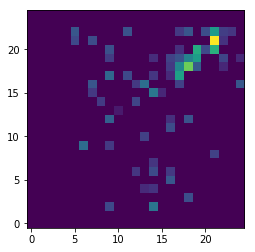

In [101]:
plt.imshow(np.log1p(masks_[0][5]),origin="lower")

In [96]:
masks_[1]

array([ 0.,  0.,  2.,  0.,  2.,  0.,  0.,  1.])

In [308]:
masks.close()

In [107]:
masks = read_events_and_labels_from_hdffiles(["Level2_nugen_numu_IC86.2012.011069.000000.formatted.hdf5",
                                              "Level2_nugen_numu_IC86.2012.011069.000001.formatted.hdf5"],
                                              number_events=16)
num_all_selected = []
for file, mask in masks.items():
    print(np.arange(len(mask))[mask])
    with h5py.File(file, "r") as hdf:
        num_current_selection = np.sum(mask)
        num_all = len(mask)
        assert num_all == hdf.attrs["number_events"]
        num_all_selected.append(num_all)
    
    print(file, num_all, num_current_selection, sum(num_all_selected))

AttributeError: 'generator' object has no attribute 'items'

In [69]:
l

array([0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1,
       0, 2, 0, 2, 0, 2, 0, 0, 1], dtype=int32)

In [35]:
hdf_r.close()

NameError: name 'hdf_r' is not defined

In [294]:
hdf_r = h5py.File("Level2_nugen_numu_IC86.2012.011069.000001.formatted.hdf5", "r")    

In [173]:
h = hdf_r["EventData"]

[]

In [174]:
list(hdf_r.attrs.keys())

['binning', 'mcdata_filename', 'runid', 'number_events']

In [37]:
testdict= dict(hdf_r.attrs)

In [86]:
sorted(testdict.keys())[1]

'mcdata_filename'

In [39]:
for k,v in sorted(testdict.items()):
    print(k, ':', v)

mcdata_filename : /home/luckyjosh/Documents/Masterarbeit/icecube_mcdata/output/Level2_nugen_numu_IC86.2012.011069.000001.hdf5
runid : 000001


In [167]:
for k, v in hdf_r.attrs.items():
    print(k, v)


runid 000000
mcdata_filename /home/luckyjosh/Documents/Masterarbeit/icecube_mcdata/output/Level2_nugen_numu_IC86.2012.011069.000000.hdf5


In [193]:
np.array([v[:] for v,m in zip(hdf_r["EventData"].values(), mask) if  m]).shape

(8, 25, 25, 25, 25)

In [162]:
hdf_r.visit(lambda name: print(name))




EventData
EventData/event_001_0
EventData/event_004_0
EventData/event_009_0
EventData/event_014_0
EventData/event_033_0
EventData/event_058_0
EventData/event_066_0
EventData/event_069_0
EventData/event_073_0
EventData/event_078_0
EventData/event_082_0
EventData/event_106_0
EventData/event_120_0
EventData/event_131_0
EventData/event_134_0
EventData/event_145_0
EventData/event_146_0
EventData/event_149_0
EventData/event_152_0
EventData/event_173_0
EventData/event_175_0
EventData/event_178_0
EventData/event_179_0
EventData/event_181_0
EventData/event_185_0
EventData/event_186_0
EventData/event_189_0
EventData/event_204_0
EventData/event_206_0
EventData/event_207_0
EventData/event_209_0
EventData/event_215_0
EventData/event_220_0
EventData/event_223_0
EventData/event_233_0
EventData/event_236_0
EventData/event_237_0
EventData/event_240_0
EventData/event_254_0
EventData/event_258_0
EventData/event_260_0
EventData/event_266_0
EventData/event_275_0
EventData/event_277_0
EventData/event_295_0


In [146]:
list(hdf_r["EventData"].values())

[<HDF5 dataset "event_001_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_004_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_009_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_014_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_033_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_058_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_066_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_069_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_073_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_078_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_082_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_106_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_120_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_131_0": shape (25, 25, 25, 25), type "<f8">,
 <HDF5 dataset "event_134_0": shape (25, 25, 25, 25), type "<f

In [968]:
hdf_r["EventLabels"][:]

array([ 0.,  2.,  2.,  1.,  0.,  1.,  0.,  2.,  0.,  0.])

In [935]:
d = hdf_r["EventData"]["event_01"][:]

In [1041]:
hdf_r.close()

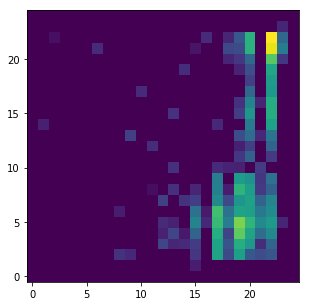

In [944]:
plt.imshow(np.log10(project_4d_histogram_onto_plane(d, projection="yz")+1), origin="lower")

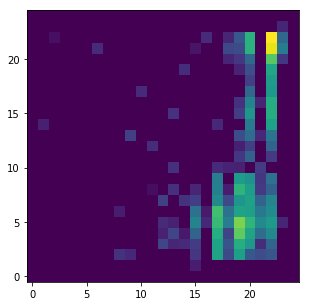

In [960]:
plt.imshow(np.log(yz.T), origin="lower")

In [853]:
!rm "binned_data.hdf5"

In [166]:
def genfiles(files):
    np.random.seed(0)
    while True:
        idx = np.random.randint(0, len(files))
        yield files[idx]

def genformat(files):
    files_ = genfiles(files)
    for file in files_:
        yield file.upper()

In [167]:
genfile = genfiles(hdf5_files)

In [168]:
count = 0
for f in genfile:
    print(f)
    count += 1
    if count == 10:
        break

Level2_nugen_numu_IC86.2012.011069.000002.formatted.hdf5
Level2_nugen_numu_IC86.2012.011069.000002.hdf5
Level2_nugen_numu_IC86.2012.011069.000000.formatted.hdf5
Level2_nugen_numu_IC86.2012.011069.000001.hdf5
Level2_nugen_numu_IC86.2012.011069.000001.hdf5
Level2_nugen_numu_IC86.2012.011069.000001.hdf5
Level2_nugen_numu_IC86.2012.011069.000000.hdf5
Level2_nugen_numu_IC86.2012.011069.000001.hdf5
Level2_nugen_numu_IC86.2012.011069.000002.hdf5
Level2_nugen_numu_IC86.2012.011069.000001.formatted.hdf5


In [169]:
count = 0
for f in genformat(hdf5_files):
    print(f)
    count += 1
    if count == 10:
        break

LEVEL2_NUGEN_NUMU_IC86.2012.011069.000002.FORMATTED.HDF5
LEVEL2_NUGEN_NUMU_IC86.2012.011069.000002.HDF5
LEVEL2_NUGEN_NUMU_IC86.2012.011069.000000.FORMATTED.HDF5
LEVEL2_NUGEN_NUMU_IC86.2012.011069.000001.HDF5
LEVEL2_NUGEN_NUMU_IC86.2012.011069.000001.HDF5
LEVEL2_NUGEN_NUMU_IC86.2012.011069.000001.HDF5
LEVEL2_NUGEN_NUMU_IC86.2012.011069.000000.HDF5
LEVEL2_NUGEN_NUMU_IC86.2012.011069.000001.HDF5
LEVEL2_NUGEN_NUMU_IC86.2012.011069.000002.HDF5
LEVEL2_NUGEN_NUMU_IC86.2012.011069.000001.FORMATTED.HDF5


In [440]:
np.random.seed(0)

In [441]:
grid1 = np.random.uniform(0,1, size=(100,2))
grid2 = np.random.uniform(0,1, size=(100,2))

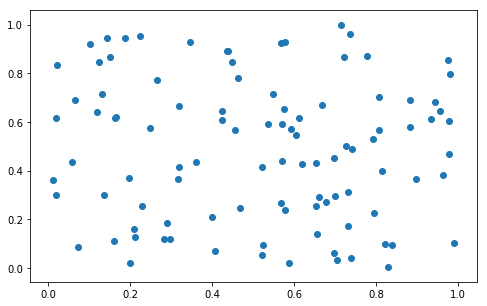

In [508]:
plt.scatter(*grid1.T)


In [446]:
hist1, _, _ = np.histogram2d(*grid1.T, bins=5)
hist1

array([[ 3.,  4.,  1.,  6.,  6.],
       [ 5.,  3.,  3.,  2.,  2.],
       [ 4.,  3.,  6.,  5.,  5.],
       [ 5.,  5.,  7.,  2.,  4.],
       [ 4.,  4.,  3.,  7.,  1.]])

In [483]:
from numpy.lib.stride_tricks import as_strided

In [556]:
def scatterbins(data, bins):
    plt.scatter(*data.T)
    hist, edgex, edgey = np.histogram2d(*data.T, bins=bins, range=((0,1),(0,1)))
    plt.hlines(edgey, xmin=min(edgex), xmax=max(edgex), alpha=0.5)
    plt.vlines(edgex, ymin=min(edgey), ymax=max(edgey), alpha=0.5)
    bin_centerx = (edgex[1:] + edgex[:-1])/2
    bin_centery = (edgey[1:] + edgey[:-1])/2
    x,y = np.meshgrid(bin_centerx,bin_centery)
    for i in range(bins):
        for j in range(bins):
            plt.text(x=x[i,j], y=y[i,j], s=str(hist[j,i]), fontdict={"fontsize":12, "color":"red"})
    H = plt.hist2d(*data.T, range=((0,1),(0,1)), bins=bins, alpha=0.1)
    plt.colorbar(orientation="horizontal")


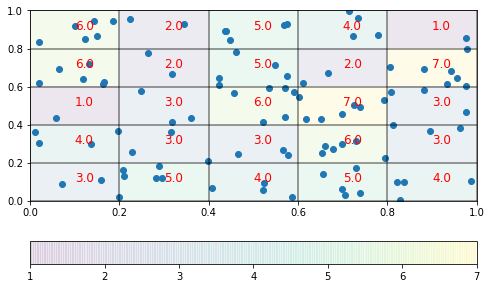

In [557]:
scatterbins(grid1, bins=5)    

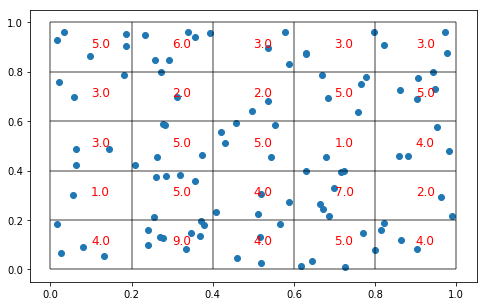

In [532]:
scatterbins(grid2, bins=5) 

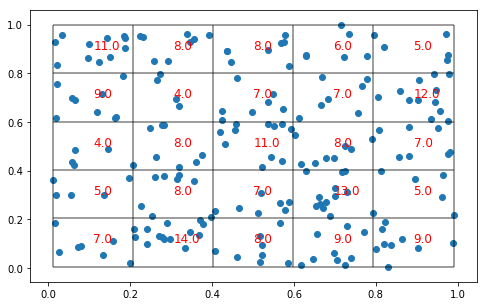

In [528]:
scatterbins(np.append(grid1,grid2, axis=0), bins=5)

In [ ]:
df_event209 = df[df.Event == 209].drop(["Run", "Event", "SubEvent", "SubEventStream", "exists", "pmt", "vector_index"], axis=1)
df_event209 = df_event209.set_index(["item","string","om"]).sort_index()
#df_event209

In [ ]:

df = f[f.keys()[1]]

In [ ]:
df_event1_pos = df[(df.Event == 1)]

In [61]:
get_dataframe_from_hdffile(hdf5_files[1]).head(10)

,Run,Event,SubEvent,SubEventStream,exists,string,om,pmt,vector_index,timebin,charge
0,1106900001,5,0,1,1,2,1,0,0,24,0.850
1,1106900001,5,0,1,1,12,44,0,0,24,0.875
2,1106900001,5,0,1,1,17,4,0,0,16,0.825
3,1106900001,5,0,1,1,21,14,0,0,22,1.225
4,1106900001,5,0,1,1,22,60,0,0,15,1.275
5,1106900001,5,0,1,1,22,60,0,1,16,0.375
6,1106900001,5,0,1,1,22,60,0,2,24,0.825
7,1106900001,5,0,1,1,25,3,0,0,14,1.325
8,1106900001,5,0,1,1,25,3,0,1,24,0.925
9,1106900001,5,0,1,1,25,5,0,0,13,1.225


In [ ]:
df_event1_pos = df_event1_pos.drop(["Run", "Event", "SubEvent", "SubEventStream", "exists", "pmt", "vector_index"], axis=1)

In [ ]:
df_event1_pos.set_index(["string","om"], inplace=True)

In [ ]:
idx

In [ ]:
plt.imshow()

In [ ]:
for k in list(idxt.keys())[0:24]:
    arr = get_position_in_timebin(idxt,timebin=range(k+1))
    #print(arr)
    histplot(arr)

In [ ]:
idxt209 = get_idxt(df_event209)

In [ ]:
for k in list(idxt209.keys())[0:24]:
    arr = get_position_in_timebin(idxt209,timebin=range(k+1))
    #print(arr)
    histplot(arr)

In [ ]:
histplot(get_position_in_timebin(idxt209,timebin=range(23,25)), cbars=True)

In [ ]:
histplot(get_position_in_timebin(idxt209, timebin=range(0,24)), cbars=True)

In [ ]:
histplot(get_position_in_timebin(idxt209, timebin=range(0,25)), cbars=True)

In [ ]:
histplot(get_position_in_timebin(idxt, timebin=range(0,25)), cbars=True, normed=False)

In [ ]:
arr = get_position_in_timebin(idxt209, timebin=range(24))[:, :3]
arr.shape

In [ ]:
arr.T

In [ ]:
hist_xyz, _= np.histogramdd(arr, bins=25)

In [ ]:
hist_txyz[0,:,:,:] ==  np.histogramdd(get_position_in_timebin(idxt209, timebin=0)[:, :3], bins=25)[0]

In [ ]:
h5file = tables.open_file("formatted.hdf5", mode="w",
                          title="Formatted mcdata")

In [ ]:
group_data = h5file.create_group("/", "mcdata", "4d binned mcdata.")

In [ ]:
group_metadata = h5file.create_group("/", "metadata", "metadata.")

In [ ]:
table = h5file.create_array(group_data, "event209", hist_txyz,
                            title="txyz data")

In [ ]:
group_metadata

In [ ]:
table.flush()

In [ ]:
h5file.flush()

In [ ]:
h5file.close()

In [ ]:
!rm formatted.hdf5

In [ ]:
h5file = tables.open_file("formatted.hdf5", mode="r",
                          title="Formatted mcdata")

In [ ]:
test = h5file.get_node("/mcdata/event209").read()

In [ ]:
h5f.keys()

In [ ]:
h5f.close()

In [ ]:
plt.imshow(np.log(np.sum(test, axis=(0)).T+1), origin="lower", extent=(-600, 600, -600, 600), cmap="viridis", vmin=0)

In [ ]:
hist_xy, _, _ = np.histogram2d(*arr[:,[0,1]].T, bins=(25,25))#, weights=np.log(charges))
hist_yz, _, _ = np.histogram2d(*arr[:,[1,2]].T, bins=(25,25))#, weights=np.log(charges))
hist_xz, _, _ = np.histogram2d(*arr[:,[0,2]].T, bins=(25,25))#, weights=np.log(charges))

fig, axes = plt.subplots(nrows=1, ncols=3)
ax_xy, ax_yz, ax_xz = np.ravel(axes)
ax_xy.set_xlabel("x")
ax_xy.set_ylabel("y")
ax_yz.set_xlabel("y")
ax_yz.set_ylabel("z")
ax_xz.set_xlabel("x")
ax_xz.set_ylabel("z")

ax_xy.set_aspect("equal")
ax_xy.imshow(hist_xy.T, origin="lower", extent=(-650, 650, -650, 650))
#ax_yz.imshow(hist_yz.T, origin="lower", extent=(-650, 650, -650, 650))
#ax_xz.imshow(hist_xz.T, origin="lower", extent=(-650, 650, -650, 650))

In [ ]:
hist, edges_x, edges_y = np.histogram2d(event1_xy.T[0], event1_xy.T[1], bins=(100,100), weights=charges)
plt.imshow(hist)

In [ ]:
fig, ax = plt.subplots(1,1)
_  = ax.hist2d(*event1_pos[:,[0,1]].T, bins=(20,20), cmap="viridis")
ax.grid(False)
ax.set_aspect(1)


In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint

np.random.seed(123)
data_0 = {"index0":np.random.randint(0,20,size=50), "index1":np.random.randint(0,20,size=50),
          "column00":np.random.uniform(0,1,size=50), "column10":np.random.uniform(0,10,size=50)}
data_1 = {"index0":np.random.randint(0,20,size=45), "index1":np.random.randint(0,20,size=45),
          "column01":np.random.uniform(0,1,size=45), "column11":np.random.uniform(0,100,size=45)}

order = ["index0", "index1","column00","column01","column10","column11"]
df_0 = pd.DataFrame(data_0)
print("first dataset:",end="\n\n")
print(df_0.head(14))
print("\nwith multi-indices:",end="\n\n")
print(df_0.set_index(["index0", "index1"]).sort_index().head(14))
print("number of rows:", len(df_0))

df_1 = pd.DataFrame(data_1)
print("\nsecond dataset:",end="\n\n")
print(df_1.head(14))
print("\nwith multi-indices",end="\n\n")
print(df_1.set_index(["index0", "index1"]).sort_index().head(14))
print("number of rows:", len(df_1))


print("\n dataframes merged and sorted on both index columns:", end="\n\n")
merged = pd.merge(df_0, df_1, on=("index0","index1"), sort=True)
merged = merged.reindex_axis(order, axis=1)
merged.set_index(["index0", "index1"], inplace=True)
merged.sort_index(inplace=True)
print(merged)
print("number of rows:", len(merged))


print("\nfirst dataset, without merged rows:",end="\n\n")
df_0_new = df_0.set_index(["index0", "index1"]).drop(merged.index,axis=0).sort_index().reset_index()
print(df_0_new.head(14))
print("number of rows:", len(df_0_new))

print("\nsecond dataset, without merged rows:",end="\n\n")
df_1_new = df_1.set_index(["index0", "index1"]).drop(merged.index,axis=0).sort_index().reset_index()
print(df_1_new.head(14))
print("number of rows:", len(df_1_new))

In [ ]:
df_0.index

In [ ]:
print(df_0.index.levels[0][df_0.index.labels[0]])
print(df_0.index.levels[1][df_0.index.labels[1]])

In [ ]:
pprint(data_0)
pprint(data_1)

In [ ]:
import scipy as sci
from scipy.spatial import ConvexHull

In [ ]:
np.random.seed(123)

In [ ]:
positions = np.random.uniform(0,3, size=(10,2))
positions[:,:]

In [ ]:
print(positions)

In [ ]:
print(*positions)

In [ ]:
print(positions[0], positions[1], positions[2])

In [ ]:
positions.T

In [ ]:
print(*positions.T)

In [ ]:
CH = ConvexHull(positions)

In [ ]:
CH.vertices

In [ ]:
CH.points

In [ ]:
x

In [ ]:
CH.points[CH.vertices][[0,-1],:]

In [ ]:
CH.simplices

In [ ]:
CH.points[CH.neighbors]

In [ ]:
CH.neighbors

In [ ]:
plt.plot(*CH.points.T, "ro")
plt.plot(*CH.points[CH.vertices].T,"go")
plt.plot(*CH.points[CH.vertices].T,"b")
plt.plot(*CH.points[CH.vertices][[0,-1],:].T,"b")
plt.plot(*CH.points[CH.vertices][CH.neighbors[:,0]].T,"yo")
for i,point in enumerate(CH.points):
    plt.annotate(str(i), xy=point, fontsize=16)
for i,point in enumerate(CH.points[CH.vertices]):
    plt.annotate(str(i), xy=point, xytext=point+np.array([-0.05,0.01]),fontsize=16, color="g")
#plt.plot([1,2,3,4,5], "o")


In [ ]:
L = [1,2,3,4]

In [ ]:
L[]

In [ ]:
import matplotlib as mpl
mpl.rcParams["figure.figsize"]=(16,9)

In [ ]:
points = np.random.rand(30, 2) 

In [ ]:
# Convex hull of a random set of points:

from scipy.spatial import ConvexHull
  # 30 random points in 2-D
hull = ConvexHull(points)

# Plot it:

import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    print(simplex)
    print(points[simplex, 0], "->", points[simplex,1])
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

# We could also have directly used the vertices of the hull, which
# for 2-D are guaranteed to be in counterclockwise order:

plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
for i,point in enumerate(points):
    plt.annotate(str(i), xy=point)
plt.show()